# PLS Regression
I'm following this paper: <https://www.sciencedirect.com/science/article/pii/S1878929316301074?via%3Dihub>

In [1]:
import glob
import os

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## Get Data

In [2]:
def get_subject_from_path(path):
    normalized_path = os.path.normpath(path)
    path_components = normalized_path.split(os.sep)
    return path_components[-2][4:]

In [5]:
# Search for all functional connectivity files and read them
fc_path = '/imaging3/owenlab/bpho/python_power_fc'
fc_paths = glob.glob(fc_path + '/**/power_fc.npy', recursive=True)

fcs = {}
for path in fc_paths:
    subject_id = get_subject_from_path(path)
    subject_fc = np.load(path)
    fcs[subject_id] = subject_fc[np.triu_indices(264, k=1)]
print("Number of functional connectivity:", len(fcs))
print("Number of features (connections):", fcs["NDARAP912JK3"].shape[0])

Number of functional connectivity: 825
Number of features (connections): 34716


## Get Labels

In [6]:
wisc_label_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects_with_WISC.csv"
wisc_labels = pd.read_csv(wisc_label_path, index_col='assessment WISC,EID')
# display(wisc_labels)

In [27]:
subject_ids = wisc_labels.index
wisc_scaled_measure = [
    'WISC_BD_Scaled', 
    'WISC_Similarities_Scaled', 
    'WISC_MR_Scaled',
    'WISC_DS_Scaled',
    'WISC_Coding_Scaled',
    'WISC_Vocab_Scaled',
    'WISC_FW_Scaled',
    'WISC_VP_Scaled',
    'WISC_PS_Scaled',
    'WISC_SS_Scaled',
    'WISC_FSIQ',
]
age_col = 'assessment Basic_Demos,Age'

fc_matrices = []
ages = []
measures = {measure: [] for measure in wisc_scaled_measure}

for subject_id in subject_ids:
    if subject_id not in fcs:
        continue
    
    fc_matrices.append(fcs[subject_id])
    ages.append(wisc_labels.at[subject_id, age_col])
    
    for measure in wisc_scaled_measure:
        measures[measure].append(
            wisc_labels.at[subject_id, f'assessment WISC,{measure}'])

ages = np.array(ages)
print("Num subjects with measures:", len(ages))

Num subjects with measures: 577


In [58]:
X = np.array(fc_matrices)

selected_measure = "WISC_FSIQ"
y = np.array(measures[selected_measure])
# y = np.array(list(measures.values())).T

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (577, 34716) y shape: (577,)


## Feature selection

### Age Binning

In [59]:
def bin_by_age(X, y, indices):
    return X[indices], y[indices]

X_bin_1, y_bin_1 = bin_by_age(X, y, np.where(ages <= 9))
X_bin_2, y_bin_2 = bin_by_age(X, y, np.where(
    np.logical_and(ages <= 12, ages > 9)))
X_bin_3, y_bin_3 = bin_by_age(X, y, np.where(ages > 12))

print("Bin 1:", len(X_bin_1), "|",
      "Bin 2:", len(X_bin_2), "|",
      "Bin 3:", len(X_bin_3),)

X = X_bin_2
y = y_bin_2

Bin 1: 175 | Bin 2: 202 | Bin 3: 200


### Variance Threshold

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(0.055)
X = sel.fit_transform(X)
print("X shape:", X.shape)

### Mutual Information

In [60]:
from sklearn.feature_selection import (
    SelectKBest, mutual_info_regression)
X = SelectKBest(mutual_info_regression, k=1500).fit_transform(X, y)
print("X shape:", X.shape)

X shape: (202, 1500)


### Select k strongest connections

In [ ]:
from sklearn.feature_selection import SelectKBest
def score_fc(X, y):
    # Take the strongest correlations regardless of sign
    sum_fc = np.absolute(np.sum(X, axis=0))
    return sum_fc

X = SelectKBest(score_fc, k=3400).fit_transform(X, y)
print("X shape:", X.shape)

## Train PLS Regression

### Determine optimal number of components

In [23]:
from scipy import stats
from sklearn.cross_decomposition import PLSRegression, PLSCanonical
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score

In [61]:
num_component = 2
kf = KFold(n_splits=10)
train_scores = []
test_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pls = PLSRegression(n_components=num_component)
    pls.fit(X_train, y_train)
    
    train_scores.append(pls.score(X_train, y_train))
    test_scores.append(pls.score(X_test, y_test))

print("Avg train score:", np.mean(train_scores))
print("Avg test score:", np.mean(test_scores))

Avg train score: 0.5824844397781328
Avg test score: 0.16262050833435443


### Use PLS to predict scores

In [62]:
train_scores = []
test_scores = []

for i in range(0, 5000):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3)
    
    pls = PLSRegression(n_components=num_component)
    pls.fit(X_train, y_train)

    y_train_pred = pls.predict(X_train)
    y_test_pred = pls.predict(X_test)
    
    train_scores.append(r2_score(y_train, y_train_pred))
    test_scores.append(r2_score(y_test, y_test_pred))

avg_train_score = np.mean(train_scores)
avg_test_score = np.mean(test_scores)

print("Train r^2:", avg_train_score)
print("Test r^2:", avg_test_score)

Train r^2: 0.6247221850793687
Test r^2: 0.15081611159839442


In [63]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lin_reg_train = LinearRegression().fit(y_train, y_train_pred)
y_train_pred_lin_reg = lin_reg_train.predict(y_train)

lin_reg_test = LinearRegression().fit(y_test, y_test_pred)
y_test_pred_lin_reg = lin_reg_test.predict(y_test)

lin_reg_train_score = lin_reg_train.score(y_train, y_train_pred)
lin_reg_test_score = lin_reg_test.score(y_test, y_test_pred)
print("Train r^2:", lin_reg_train_score)
print("Test r^2:", lin_reg_test_score)

Train r^2: 0.575109995484266
Test r^2: 0.31086050119469766


NameError: name 'measure_text' is not defined

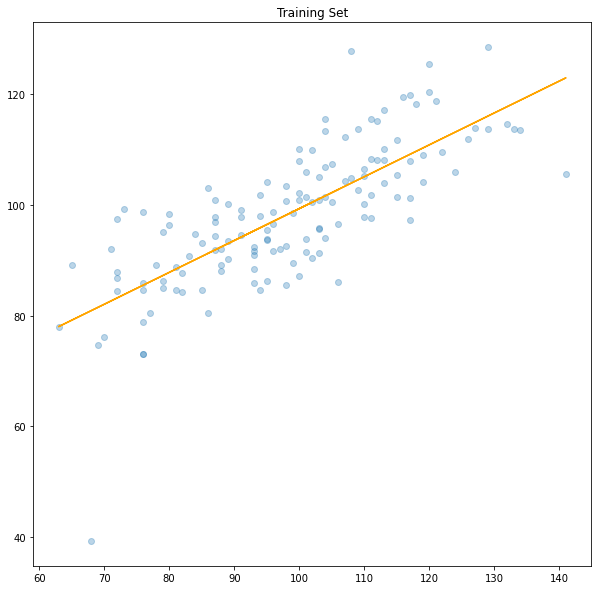

In [64]:
plt.figure(1, figsize=(10, 10))
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot(y_train, y_train_pred_lin_reg, color='orange')
plt.title("Training Set")
plt.xlabel(f'True {measure_text}')
plt.ylabel(f'Predicted {measure_text}')
# plt.annotate(f"r-squared = {avg_train_score:.3f}", (6, 16))
plt.show()

In [ ]:
plt.figure(1, figsize=(10, 10))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot(y_test, y_test_pred_lin_reg, color='orange')
plt.title("Testing Set")
plt.xlabel(f'True {measure_text}')
plt.ylabel(f'Predicted {measure_text}')
# plt.annotate(f"r-squared = {avg_test_score:.3f}", (6, 16))
plt.show()

In [ ]:
plt.figure(1, figsize=(10, 10))
plt.hist(x=test_scores)
plt.title("Test Score Distribution")
plt.xlabel('Score')
plt.ylabel('Number of Scores')
plt.show()